# Project: FIFA Project


## Context
The datasets provided include the players data for the Career Mode from FIFA 15 to FIFA 20 ("players_20.csv"). The data allows multiple comparison of the same players across the last 6 version of the videogame.

## Content
Every player available in FIFA 15, 16, 17, 18, 19, and also FIFA 20
100+ attributes
URL of the scraped player
Player positions, with the role in the club and in the national team
Player attributes with statistics as Attacking, Skills, Defense, Mentality, GK Skills, etc.
Player personal data like Nationality, Club, DateOfBirth, Wage, Salary, etc.

## Acknowledgements
Data has been scraped from the publicly available website https://sofifa.com.

### Imports 

In [954]:
# Data wrangling and statistical imports
import re
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew
from math import pi

# Visualisation imports and settings.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style # for styling the graphs
# style.available (to know the available list of styles)
style.use('ggplot') # chosen style
#[f.name for f in matplotlib.font_manager.fontManager.afmlist] (to know the available list of fonts)
plt.rc('xtick',labelsize=13) # to globally set the tick size
plt.rc('ytick',labelsize=13) # to globally set the tick size
import seaborn as sns
import squarify
from matplotlib import patches
from scipy.spatial import ConvexHull

# sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeRegressor

# To print multiple outputs together
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "last_expr" # to remove matplotlib text outputs.

# Change column display number during print
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# To display float with 2 decimal, avoid scientific printing
pd.options.display.float_format = '{:.2f}'.format

### Load the data

In [12]:
fifa_17 = pd.read_csv('players_17.csv')
fifa_18 = pd.read_csv('players_18.csv')
fifa_19 = pd.read_csv('players_19.csv')
fifa_20 = pd.read_csv('players_20.csv')

fifa_17['year'] = 2017
fifa_18['year'] = 2018
fifa_19['year'] = 2019
fifa_20['year'] = 2020

fifa = pd.concat([fifa_17, fifa_18, fifa_19])
fifa.reset_index(drop=True, inplace=True)

# Dropping unnecessary columns
fifa.drop(fifa.loc[:,'ls':'rb'].columns, axis=1, inplace=True)
fifa.drop(fifa.loc[:,'release_clause_eur':'player_traits'].columns, axis=1, inplace=True)

fifa.head(3)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,31,1985-02-05,185,80,Portugal,Real Madrid,94,94,87000000,340000,"LW, LM, ST",Right,5,4,5,High/Low,C. Ronaldo,Yes,84+2,93-2,87+1,82+1,88+1,93,81-7,77,72,92+1,91,92-1,90,96+4,63+1,94,95+1,92+2,80+1,92-1,63+1,29,94+1,85+4,85,86,22,31,23,7,11,15,14,11,2017
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,29,1987-06-24,170,72,Argentina,FC Barcelona,93,93,89000000,340000,RW,Left,5,4,4,Medium/Medium,Messi,Yes,77-3,95+2,71,88,85,97+1,89,90,87+8,95-1,92-3,87-3,90-2,95+3,95,83+3,68,74-1,59,88,48,22,93+3,90,74,94,13,28+5,26+5,6,11,15,14,8,2017
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar,Neymar da Silva Santos Junior,24,1992-02-05,174,68,Brazil,FC Barcelona,92,95,109000000,260000,LW,Right,5,5,5,High/Medium,Neymar,Yes,75+3,89+1,62,81+3,83,96+2,78,79,75+1,95+2,93+2,90,96+4,88+2,82-2,78,61,70-9,49+4,77+4,56,36,90+1,80+1,81,80,21,24,33,9,9,15,15,11,2017


In [14]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52371 entries, 0 to 52370
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   sofifa_id                   52371 non-null  int64 
 1   player_url                  52371 non-null  object
 2   short_name                  52371 non-null  object
 3   long_name                   52371 non-null  object
 4   age                         52371 non-null  int64 
 5   dob                         52371 non-null  object
 6   height_cm                   52371 non-null  int64 
 7   weight_kg                   52371 non-null  int64 
 8   nationality                 52371 non-null  object
 9   club                        52371 non-null  object
 10  overall                     52371 non-null  int64 
 11  potential                   52371 non-null  int64 
 12  value_eur                   52371 non-null  int64 
 13  wage_eur                    52371 non-null  in

In [15]:
# Few errors found during EDA.
fifa.loc[fifa['short_name'] == 'Neymar', 'short_name'] = 'Neymar Jr'
fifa.loc[fifa['club'] == 'Belgium', 'club'] = 'Borussia Dortmund'
fifa.loc[35023, 'club'] = 'Paris Saint-Germain'
fifa.loc[511, 'club'] = 'River Plate'

### Which club(s) spends the highest on their players ?

In [16]:
X = fifa.groupby(['year','club'])['wage_eur'].sum()
for year in range(2017,2020):
    print(year,X[year].idxmax(), X[year].max())

2017 Real Madrid 2734000
2018 Real Madrid 4751000
2019 Real Madrid 4961000


 - Well, **Real Madrid** seems to spend the highest on their players. This is quite obvious given they have such prolific players like Gareth Bale, Cristiano Ronaldo, Karim Benzema, Sergio Ramos, etc.

### Which country has the maximum mumber of players in fifa ? 

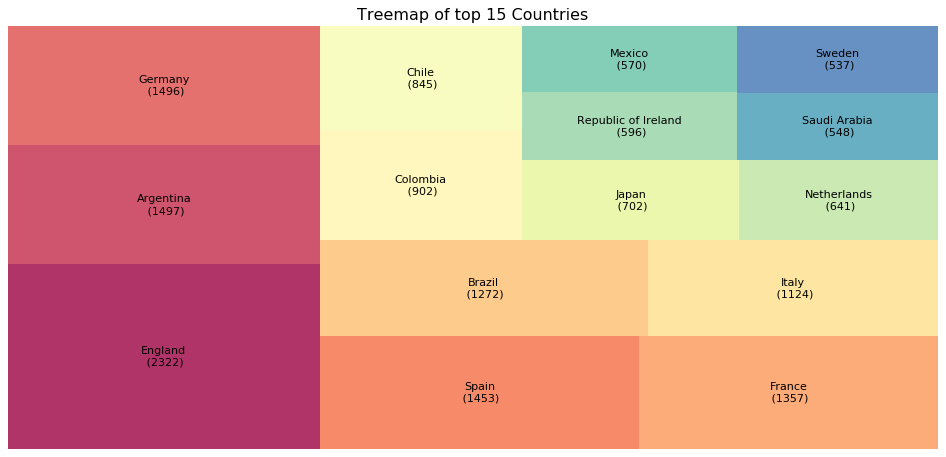

In [17]:
nat_count = fifa.groupby('nationality')['sofifa_id'].nunique().sort_values(ascending=False).head(15).reset_index(name='counts')

labels = nat_count.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = nat_count['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(15,7), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Treemap of top 15 Countries')
plt.axis('off')
plt.show()

- A huge amount of players belong to **England**.

### Clubbing player positions into one general position of the player.

In [18]:
foward = ['ST','LW','RW','SS','CF']
defender = ['RWB','LWB','LB','RB','CB']
midfielder = ['CM','CDM','CAM','LM','RM']
goalkeeper = ['GK']
def general_position(x):
    if len(re.findall('|'.join(defender), x)) > 0:
        position = 'Defender'
    elif len(re.findall('|'.join(goalkeeper), x)) > 0:
        position = 'Goalkeeper'
    elif len(re.findall('|'.join(foward), x)) >= len(re.findall('|'.join(midfielder), x)):
        position='Foward'
    else:
        position='Midfielder'
    return position

gen_position = fifa['player_positions'].apply(lambda x: general_position(x))
fifa.insert(15, 'gen_position', gen_position)

### Players positions with their preferred foot.

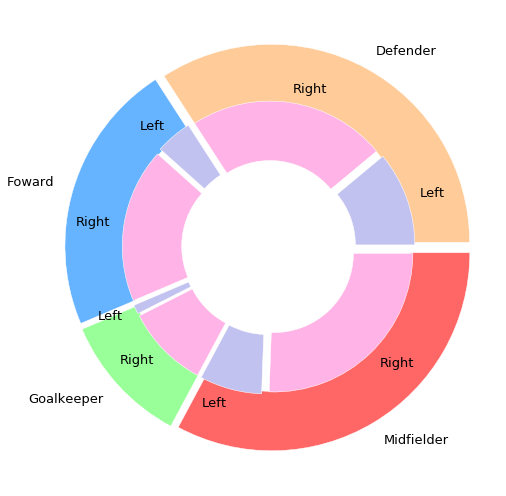

In [19]:
pos_foot_df = fifa.groupby(['preferred_foot','gen_position'])['short_name'].nunique().unstack('preferred_foot')

fig, ax = plt.subplots(figsize=(7,7))
ax.axis('equal')
width = 0.3

explode = (0.03,0.03,0.03,0.03) 
explode_inner = (0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04)

cout = ['#ffcc99','#66b3ff','#99ff99','#ff6666',]
pie, _ = ax.pie(pos_foot_df.sum(axis=1), radius=1, labels=pos_foot_df.index, colors=cout, explode=explode)
plt.setp( pie, width=width, edgecolor='white')

cin = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
labels = list(pos_foot_df.columns) * 4
pie2, _ = ax.pie(pos_foot_df.values.flatten(), radius=1-width, labels=labels, colors=cin, explode=explode_inner)
plt.setp( pie2, width=width, edgecolor='white')
# plt.legend()
plt.tight_layout()
plt.show()

In [20]:
fifa.groupby('preferred_foot')['overall'].mean()

preferred_foot
Left    66.73
Right   66.12
Name: overall, dtype: float64

- Majority of the players are **right-footed** in all three positions.
- A very less amount of **goalkeepers** are **left-footed**.
- Though majority of the players are right footed, the average `overall` stats for both type of players are **similar.** This indicates that there might be some left-footed players with exceptional `overall` ratings.

### Combining the player attributes.

In [21]:
def sub(numlist):
     result = numlist[0]
     for n in numlist[1:]:
             result -= n
     return result

def sum_or_sub(x):
    if '+' in str(x):
        result = sum(list(map(int, x.split('+'))))
        return int(result)
    if '-' in str(x):
        result = sub(list(map(int, x.split('-'))))
        return int(result)
    else:
        return int(x)

#sum_or_sub('77-3')

In [22]:
fifa['attacking_crossing'] = fifa['attacking_crossing'].apply(lambda x: sum_or_sub(x))
fifa['attacking_finishing'] = fifa['attacking_finishing'].apply(lambda x: sum_or_sub(x))
fifa['attacking_heading_accuracy'] = fifa['attacking_heading_accuracy'].apply(lambda x: sum_or_sub(x))
fifa['attacking_short_passing'] = fifa['attacking_short_passing'].apply(lambda x: sum_or_sub(x))
fifa['attacking_volleys'] = fifa['attacking_volleys'].apply(lambda x: sum_or_sub(x))
fifa['skill_dribbling'] = fifa['skill_dribbling'].apply(lambda x: sum_or_sub(x))
fifa['skill_curve'] = fifa['skill_curve'].apply(lambda x: sum_or_sub(x))
fifa['skill_fk_accuracy'] = fifa['skill_fk_accuracy'].apply(lambda x: sum_or_sub(x))
fifa['skill_long_passing'] = fifa['skill_long_passing'].apply(lambda x: sum_or_sub(x))
fifa['skill_ball_control'] = fifa['skill_ball_control'].apply(lambda x: sum_or_sub(x))
fifa['movement_acceleration'] = fifa['movement_acceleration'].apply(lambda x: sum_or_sub(x))
fifa['movement_sprint_speed'] = fifa['movement_sprint_speed'].apply(lambda x: sum_or_sub(x))
fifa['movement_agility'] = fifa['movement_agility'].apply(lambda x: sum_or_sub(x))
fifa['movement_reactions'] = fifa['movement_reactions'].apply(lambda x: sum_or_sub(x))
fifa['movement_balance'] = fifa['movement_balance'].apply(lambda x: sum_or_sub(x))
fifa['power_shot_power'] = fifa['power_shot_power'].apply(lambda x: sum_or_sub(x))
fifa['power_jumping'] = fifa['power_jumping'].apply(lambda x: sum_or_sub(x))
fifa['power_stamina'] = fifa['power_stamina'].apply(lambda x: sum_or_sub(x))
fifa['power_strength'] = fifa['power_strength'].apply(lambda x: sum_or_sub(x))
fifa['power_long_shots'] = fifa['power_long_shots'].apply(lambda x: sum_or_sub(x))
fifa['mentality_aggression'] = fifa['mentality_aggression'].apply(lambda x: sum_or_sub(x))
fifa['mentality_interceptions'] = fifa['mentality_interceptions'].apply(lambda x: sum_or_sub(x))
fifa['mentality_positioning'] = fifa['mentality_positioning'].apply(lambda x: sum_or_sub(x))
fifa['mentality_vision'] = fifa['mentality_vision'].apply(lambda x: sum_or_sub(x))
fifa['mentality_penalties'] = fifa['mentality_penalties'].apply(lambda x: sum_or_sub(x))
fifa['mentality_composure'] = fifa['mentality_composure'].apply(lambda x: sum_or_sub(x))
fifa['defending_marking'] = fifa['defending_marking'].apply(lambda x: sum_or_sub(x))
fifa['defending_standing_tackle'] = fifa['defending_standing_tackle'].apply(lambda x: sum_or_sub(x))
fifa['defending_sliding_tackle'] = fifa['defending_sliding_tackle'].apply(lambda x: sum_or_sub(x))
fifa['goalkeeping_diving'] = fifa['goalkeeping_diving'].apply(lambda x: sum_or_sub(x))
fifa['goalkeeping_handling'] = fifa['goalkeeping_handling'].apply(lambda x: sum_or_sub(x))
fifa['goalkeeping_kicking'] = fifa['goalkeeping_kicking'].apply(lambda x: sum_or_sub(x))
fifa['goalkeeping_positioning'] = fifa['goalkeeping_positioning'].apply(lambda x: sum_or_sub(x))
fifa['goalkeeping_reflexes'] = fifa['goalkeeping_reflexes'].apply(lambda x: sum_or_sub(x))

In [23]:
def attacking(data):
    return int(round((data[['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys']].mean()).mean()))

def skill(data):
    return int(round((data[['skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control']].mean()).mean()))

def movement(data):
    return int(round((data[['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance']].mean()).mean()))

def power(data):
    return int(round((data[['power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots']].mean()).mean()))

def mentality(data):
    return int(round((data[['mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure']].mean()).mean()))

def defending(data):
    return int(round((data[['defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle']].mean()).mean()))

def goalkeeping(data):
    return int(round((data[['goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']].mean()).mean()))

def rating(data):
    return int(round((data[['potential', 'overall']].mean()).mean()))

fifa['attacking'] = fifa.apply(attacking, axis=1)
fifa['skill'] = fifa.apply(skill, axis=1)
fifa['movement'] = fifa.apply(movement, axis=1)
fifa['power'] = fifa.apply(power, axis=1)
fifa['mentality'] = fifa.apply(mentality, axis=1)
fifa['defending'] = fifa.apply(defending, axis=1)
fifa['goalkeeping'] = fifa.apply(goalkeeping, axis=1)
fifa['rating'] = fifa.apply(rating, axis=1)

### What are the necessary attributes corresponding to different positions ? 

In [24]:
player_features = ('attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes')


for i, val in fifa.groupby(fifa['gen_position'])[player_features].mean().iterrows():
    print('\033[1m Position {}:\033[0m {}, {}, {}, {}, {}, {} \n'.format(i, *tuple(val.nlargest(7).index)))

 Position Defender: power_strength, power_jumping, power_stamina, defending_standing_tackle, mentality_aggression, movement_sprint_speed 

 Position Foward: movement_sprint_speed, movement_acceleration, movement_agility, movement_balance, power_shot_power, skill_ball_control 

 Position Goalkeeper: goalkeeping_reflexes, goalkeeping_diving, goalkeeping_positioning, goalkeeping_handling, goalkeeping_kicking, power_strength 

 Position Midfielder: movement_balance, movement_agility, movement_acceleration, power_stamina, movement_sprint_speed, attacking_short_passing 



- All these **attributes** are quite **intuitive** for their respective **positions**. 
- For example, it is necessary for a **foward** to not only have good **speed, acceleration, agility** and **ball control** in order to dribble past defenders but also **balance** and **shot power** to score against goalkeepers.

### Let's compare the general attributes of different positions.

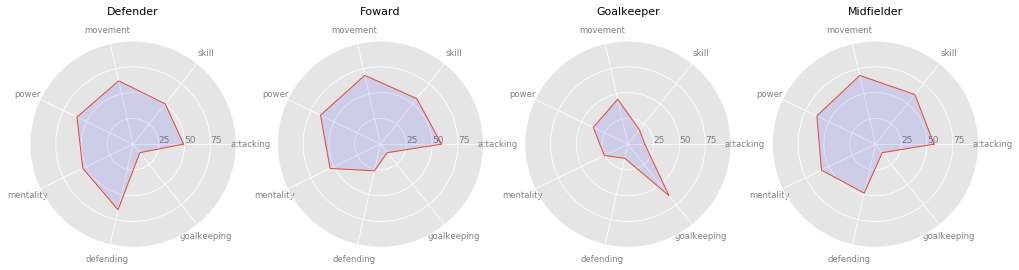

In [25]:
player_features = ('attacking',
       'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping')

idx = 1
plt.figure(figsize=(17,100))
for position_name, features in fifa.groupby(fifa['gen_position'])[player_features].mean().iterrows():
    top_features = dict(features)
    
    # number of variable
    categories=top_features.keys()
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = list(top_features.values())
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1, 4, idx, polar=True)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8.5)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=9)
    plt.ylim(0,100)    
    plt.subplots_adjust(hspace = 0.5)    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title(position_name, size=11, y=1.1)  
    idx += 1 

### Let's investigate the players.

In [26]:
players_df = fifa[['short_name', 'age', 'nationality', 'club','gen_position','attacking',
       'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping',
       'rating','year']]
players_df.head(3)

,short_name,age,nationality,club,gen_position,attacking,skill,movement,power,mentality,defending,goalkeeping,rating,year
0,Cristiano Ronaldo,31,Portugal,Real Madrid,Foward,87,82,87,91,75,25,12,94,2017
1,L. Messi,29,Argentina,FC Barcelona,Foward,83,93,91,75,71,26,11,93,2017
2,Neymar Jr,24,Brazil,FC Barcelona,Foward,79,86,91,67,71,26,12,94,2017


### Best players over the years according to their `overall` stats.

In [27]:
players_df.groupby('short_name')[['rating','nationality','age']].max().sort_values(by='rating', ascending=False).head(10)


,rating,nationality,age
short_name,,,
Neymar Jr,94,Brazil,26
L. Messi,94,Argentina,31
Cristiano Ronaldo,94,Portugal,33
P. Dybala,92,Argentina,24
L. Suárez,92,Uruguay,31
K. De Bruyne,92,Belgium,27
M. Neuer,92,Germany,32
J. Oblak,92,Slovenia,25
De Gea,92,Spain,27


- Even at the age of 30+, **Lionel Messi** and **Cristiano Ronaldo** are among the highest rated players.
- Almost all of these marquee players are **above 25 years** of age.

### Since most of the players in the above list were above 25 years of age, let's look at some of the most promising youth players

In [28]:
# select players who are currently U-21
teen_df = fifa[(fifa['age'] <= 21) & (fifa['year'] == 2019)]
teen_df.head(3)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,gen_position,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,attacking,skill,movement,power,mentality,defending,goalkeeping,rating
34642,231747,https://sofifa.com/player/231747/kylian-mbappe...,K. Mbappé,Kylian Mbappé,19,1998-12-20,178,73,France,Paris Saint-Germain,87,95,72000000,83000,"RW, ST, RM",Foward,Right,3,4,5,High/Medium,Lean,Yes,76,86,77,82,78,89,77,63,73,90,96,96,92,85,83,79,75,83,71,76,62,38,85,84,70,86,34,34,32,13,5,7,11,6,2019,80,78,90,77,71,33,8,91
34757,230666,https://sofifa.com/player/230666/gabriel-ferna...,Gabriel Jesus,Gabriel Fernando de Jesus,21,1997-04-03,175,73,Brazil,Manchester City,83,92,41000000,130000,ST,Foward,Right,2,3,4,High/High,Normal,Yes,66,84,74,76,72,86,76,54,66,85,87,85,92,86,91,78,77,84,68,73,73,32,88,77,78,82,53,23,19,13,8,6,6,15,2019,74,73,88,76,72,32,10,88
34759,222737,https://sofifa.com/player/222737/malcom-filipe...,Malcom,Malcom Filipe Silva de Oliveira,21,1997-02-26,172,74,Brazil,FC Barcelona,83,90,36500000,155000,RW,Foward,Left,2,4,4,Medium/Medium,Normal,No,79,75,57,83,71,85,77,81,73,85,87,82,92,80,84,85,58,74,64,85,53,26,79,84,68,78,21,28,17,8,14,15,7,9,2019,73,80,85,73,65,22,11,86


In [29]:
teen_df.groupby('short_name')[['rating','nationality','age']].max().sort_values(by='rating', ascending=False).head(10)

,rating,nationality,age
short_name,,,
K. Mbappé,91,France,19
G. Donnarumma,88,Italy,19
Gabriel Jesus,88,Brazil,21
Malcom,86,Brazil,21
Arthur,86,Brazil,21
M. de Ligt,86,Netherlands,18
L. Bailey,86,Jamaica,20
O. Dembélé,86,France,21
M. Rashford,85,England,20


 - **Kylian Mbappè** is indeed doing wonders at this age.

### Is there any trend between a player's age and its ratings ?

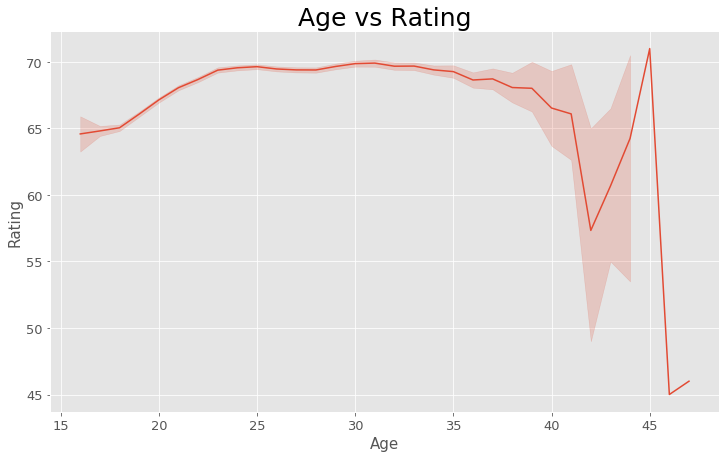

In [30]:
plt.figure(figsize=(12,7))
sns.lineplot(players_df['age'], players_df['rating']);
plt.title('Age vs Rating', size=25);
plt.xlabel('Age', size=15);
plt.ylabel('Rating', size=15);

- Seems like a player's **rating** starts to **increase** with age and then starts to **decline** once the player is **above 33** years.
- Few players are **40+** whose **ratings** still seem to **increase**, these might be the **goalkeepers**.

### We saw in the earlier plot that there were few players above 40 years whose ratings were still above average. Let's invesetigate these players.

In [31]:
players_df[(players_df['age'] > 40) & (players_df['rating'] > players_df['rating'].mean())][['short_name','age','nationality','club','gen_position']]

,short_name,age,nationality,club,gen_position
3766,E. El-Hadary,43,Egypt,Egypt,Goalkeeper
4299,O. Pérez,43,Mexico,Pachuca,Goalkeeper
5124,Esteban,41,Spain,Real Oviedo,Goalkeeper
5946,J. Jääskeläinen,41,Finland,Wigan Athletic,Goalkeeper
21415,O. Pérez,44,Mexico,Pachuca,Goalkeeper
22498,E. El Hadary,44,Egypt,Al Taawoun,Goalkeeper
23209,Quim,41,Portugal,CD Aves,Goalkeeper
35710,J. Villar,41,Paraguay,Paraguay,Goalkeeper
38161,B. Nivet,41,France,ESTAC Troyes,Midfielder
38932,O. Pérez,45,Mexico,Pachuca,Goalkeeper


 - As suspected, almost **all** of the players are **goalkeepers**.

### Distribution of ratings in top 7 clubs.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

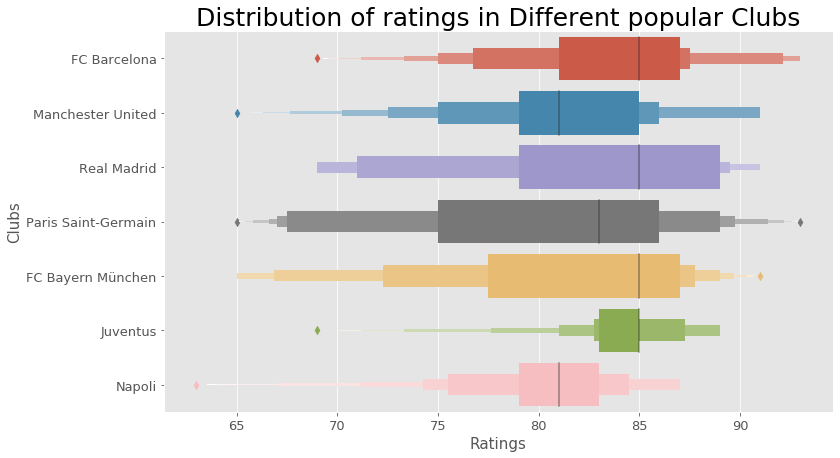

In [32]:
best_clubs = list(fifa.groupby('club')['rating'].mean().sort_values(ascending=False).head(7).index)
data_clubs = fifa.loc[fifa['club'].isin(best_clubs) & fifa['rating']]

plt.figure(figsize=(12,7));
sns.boxenplot(y = data_clubs['club'], x = data_clubs['rating']);
plt.title('Distribution of ratings in Different popular Clubs', size=25);
plt.xlabel('Ratings', size=15);
plt.ylabel('Clubs', size=15);

- **Juventus** seems to be the best club in this dataset as almost all of its players have **ratings above 80**.

### How are weights of players distributed among different positions ?

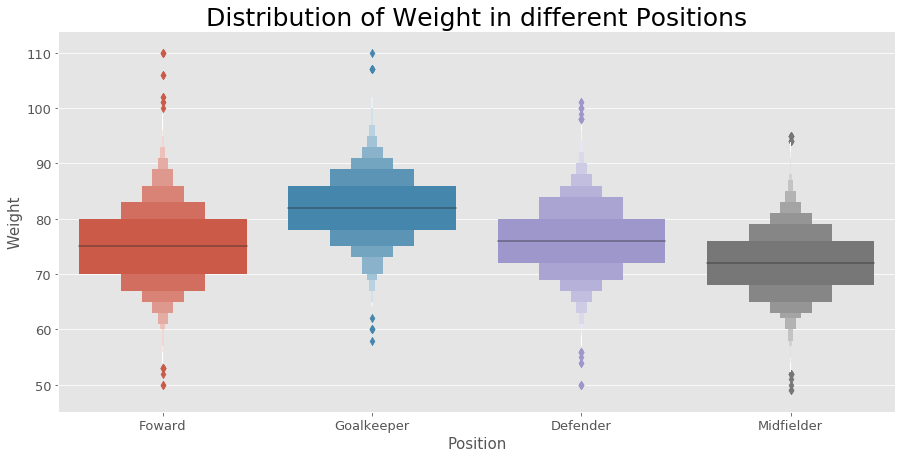

In [33]:
plt.figure(figsize=(15,7))
sns.boxenplot(fifa['gen_position'], fifa['weight_kg']);
plt.title('Distribution of Weight in different Positions', size=25);
plt.xlabel('Position', size=15);
plt.ylabel('Weight', size=15);

- **Midfielders** have **lower** weights as their role requires them to be **agile**.

### Let's check the skill moves of players of different physical stats.

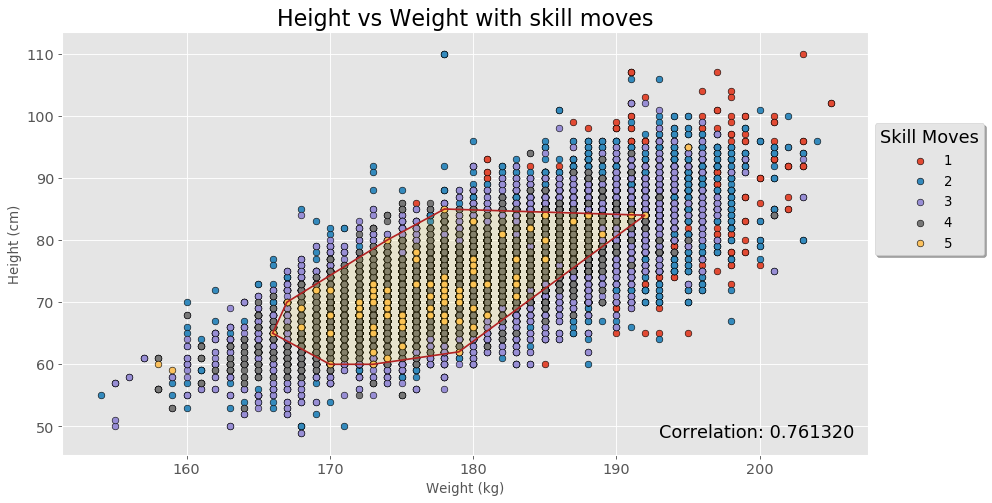

In [1026]:
categories = np.unique(fifa['skill_moves'])

fig = plt.figure(figsize=(13, 7), dpi= 80, facecolor='w', edgecolor='k')    
for i, category in enumerate(categories):
    plt.style.use('ggplot');
    plt.scatter(x='height_cm', y='weight_kg', data=fifa.loc[fifa.skill_moves==category, :], label=str(category), edgecolors='black', linewidths=.5);
    
# Encircling
# https://stackoverflow.com/questions/44575681/how-do-i-encircle-different-data-sets-in-scatter-plot
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

# Select data to be encircled
q1 = fifa['height_cm'].quantile(0.25) # removing outliers from height for better visual boundary
q3 = fifa['height_cm'].quantile(0.75)
iqr = q3 - q1
fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)
height_mask = (fifa['height_cm'] > fence_low) & (fifa['height_cm'] < fence_high)

q1 = fifa['weight_kg'].quantile(0.25) # removing outliers from weight for better visual boundary
q3 = fifa['weight_kg'].quantile(0.75)
iqr = q3 - q1
fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)
weight_mask = (fifa['weight_kg'] > fence_low) & (fifa['weight_kg'] < fence_high)


fifa_encircle_data = fifa[(height_mask) & (weight_mask) & (fifa['skill_moves'] == 5)] 

# Draw polygon surrounding vertices    
encircle(fifa_encircle_data.height_cm, fifa_encircle_data.weight_kg, ec="k", fc="gold", alpha=0.1)
encircle(fifa_encircle_data.height_cm, fifa_encircle_data.weight_kg, ec="firebrick", fc="none", linewidth=1.5)

# Decorations
plt.rc('font', size=16);
plt.text(x=0.9, y=0.1, transform=ax.transAxes, s="Correlation: %f" % np.corrcoef(fifa['weight_kg'], fifa['height_cm'])[0][1]);
plt.xlabel('Weight (kg)');
plt.ylabel('Height (cm)');
plt.title("Height vs Weight with skill moves", fontsize=20);
plt.legend(title='Skill Moves', bbox_to_anchor=(1, 0.8), fancybox=True, shadow=True,fontsize=12); 
plt.show()

 - **Height** and **weight** of the players have **strong positive correlation**.
 - We see that almost all **highly** skillful players have **average** physical stats.

### We observe from the above plot that few players had higher physical stats than average but were still rated 5 stars, let's investigate these players.

In [35]:
abv_avg = fifa[(fifa['height_cm'] > fifa['height_cm'].mean()) & (fifa['skill_moves'] == 5) & (fifa['weight_kg'] > fifa['weight_kg'].mean())]
abv_avg.groupby('short_name').agg({'club':'min','rating':'mean'})

,club,rating
short_name,,
A. Yarmolenko,Borussia Dortmund,81.00
Cristiano Ronaldo,Juventus,94.00
F. Bernardeschi,Juventus,84.00
J. Botaka,Sint-Truidense VV,69.00
P. Pogba,Manchester United,90.33
R. Kishna,ADO Den Haag,77.00
V. Aboubakar,FC Porto,80.50
Y. Bolasie,Aston Villa,77.67
Z. Ibrahimović,LA Galaxy,85.00


- Well players like **Ibrahimović, Ronaldo, Pogba** do have **extraordinary** physical stats.
- Also, notice how these players have **higher** ratings as compared to the **average** rating of 68.

### How are ratings distributed among different skill ratings ?

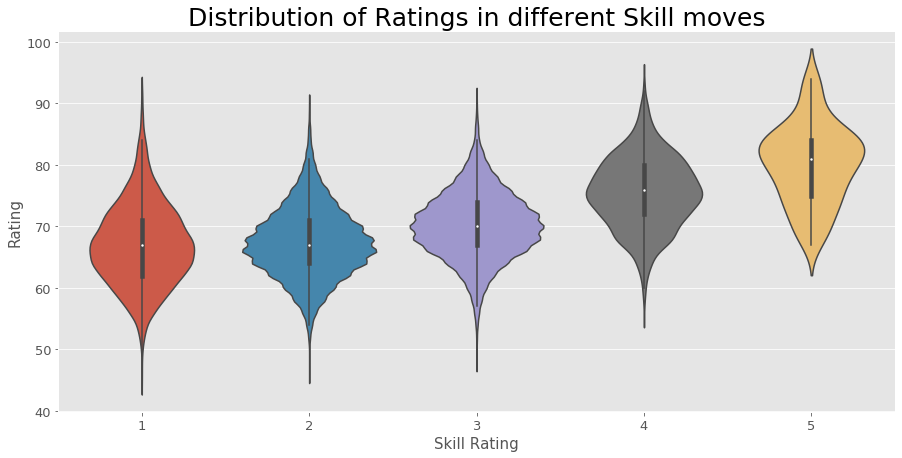

In [36]:
plt.figure(figsize=(15,7))
sns.violinplot(fifa['skill_moves'], fifa['rating']);
plt.title('Distribution of Ratings in different Skill moves', size=25);
plt.xlabel('Skill Rating', size=15);
plt.ylabel('Rating', size=15);

- **1 star** and **2 star** rated players have **similar** overall ratings.
- **5 star** rated players tend to have **higher** ratings.

### It's time for the summer market transfer! Let's create a model to predict a player's value given its overall, potential and current wage.

In [995]:
X = fifa[['overall','potential','wage_eur']]
y = fifa['value_eur']

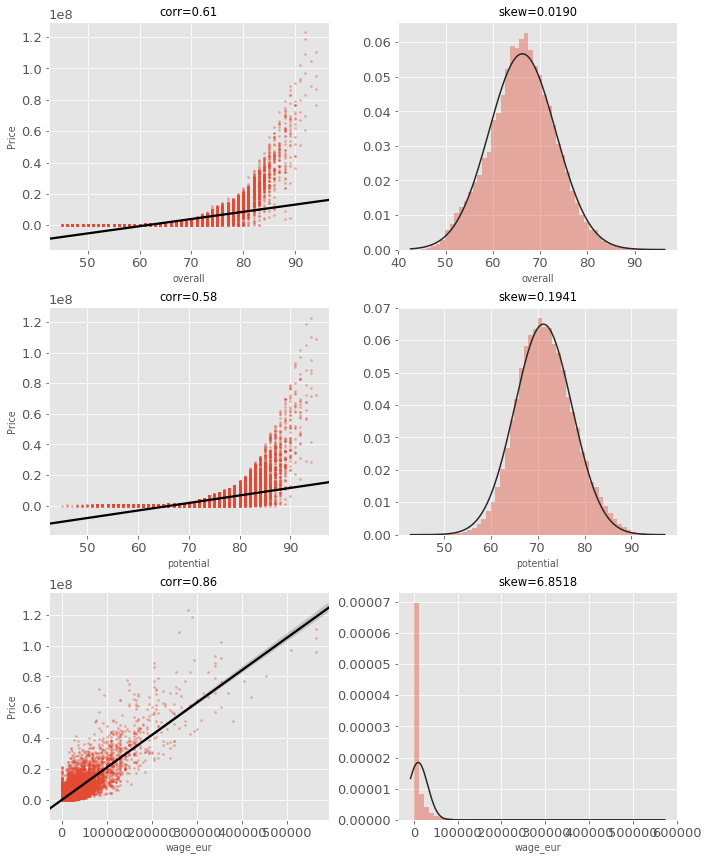

In [664]:
plt.rc('font', size=8)
fcols = 2
frows = len(X.columns)
plt.figure(figsize=(5*fcols,4*frows));

i=0
for col in X.columns:
    i+=1
    ax=plt.subplot(frows,fcols,i);
    sns.regplot(x=col, y=y, data=X, ax=ax,
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col);
    plt.ylabel('Price');
    plt.title('corr='+'{:.2f}'.format(np.corrcoef(X[col], y)[0][1]));
    
    i+=1
    ax=plt.subplot(frows,fcols,i);
    sns.distplot(X[col].dropna() , fit=stats.norm, kde=False);
    plt.title('skew='+'{:.4f}'.format(stats.skew(X[col])))
    plt.xlabel(col);
plt.tight_layout()

- `overall` & `potential` exhibit an **exponential** relationship with the target.

In [996]:
X['wage_eur'] = np.log1p(X['wage_eur'])

In [997]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rkfold = RepeatedKFold(n_repeats=5, n_splits=5)

In [998]:
def cv_score(model):
    scores = cross_val_score(model, X_train, y_train, cv=rkfold, scoring='r2')
    print('CV score: {:.2%} (+/- {:.2})'.format(scores.mean(), scores.std()))

## Poly LR

In [1011]:
model1 = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(normalize=True))])
model1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=4, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linear',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=True))],
         verbose=False)

In [1012]:
cv_score(model1)

CV score: 94.34% (+/- 0.007)


## kNN

In [1013]:
model2 = KNeighborsRegressor(n_neighbors=9, n_jobs=-1)
model2.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [1014]:
cv_score(model2)

CV score: 94.49% (+/- 0.0067)


## DT

In [1003]:
model3 = DecisionTreeRegressor(max_depth=5)
model3.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [1004]:
cv_score(model3)

CV score: 92.20% (+/- 0.01)


#### Note: All hyperparameters were tuned using GridSearchCV.

## Using kNN to predict on the test set

In [1017]:
preds = model2.predict(X_test)
print('R2 score on test set: {:.2%}'.format(r2_score(y_test, preds)))

R2 score on test set: 95.13%
